# Jupyter Notebook to create the file: efficiencies.npz

Create a NumPy binary file having the polarization and flipping efficiencies vs. neutron wavelength.  This file is needed by Module2 in the time-of-flight binning routine.

The routine requires four neutron cross-section measurements of the beam (4 files) and files corresponding to the background (another 4 files).

Formulas used to calculate the efficiencies are shown in the PowerPoint file.

The notebook calls a Python routine written by T. Charlton.

M.R. Fitzsimmons 
03.12.22

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import getopt
import sys
import numpy as np
import os
import scipy.io as sio
import scipy.optimize as sop

# Run without options to get directions

In [2]:
run -i get_calibration_data.py 

Options:
 	--help 
 	--back=BACKFILE 
 	--input=INPUTFILE 
 	--output=OUTPUTFILE
	Example:
 net_data.py --back=BackFileofData --input=FileNameofInputData --output=FileNameofOutputData
    Note: The default read directory is /Users/mf3/Dropbox (ORNL)/Neutron Scattering/Reflectometry_code/Efficiencies/
    Note: The suffix On_On.txt and so forth will be appended by the code; do not include.
    Note: The prefixes of each file type, back or ROI, are the same to the file type.
    Note: The files are assumed to have the same number of rows, wavelengths and tofs.


# Run to load the data from files.
The slit settings for runs 34638 & 34639 were: s1h=1 mm, s1v = 24 mm, s3h = 1mm, s3v = 14 mm. The imaged cross section
    of the beam transmitted through the IPNS analyzer on the detector was 4 mm wide by 12 mm tall. MagH was energized
    to produce B = 0.01 T.

In [3]:
run -i get_calibration_data.py --back=bg34638_entry- --input=134638_entry- --output=outp.txt

/Users/mf3/Dropbox (ORNL)/Neutron Scattering/Reflectometry_code/Efficiencies/bg34638_entry-On_On.txt
/Users/mf3/Dropbox (ORNL)/Neutron Scattering/Reflectometry_code/Efficiencies/bg34638_entry-Off_Off.txt
/Users/mf3/Dropbox (ORNL)/Neutron Scattering/Reflectometry_code/Efficiencies/bg34638_entry-Off_On.txt
/Users/mf3/Dropbox (ORNL)/Neutron Scattering/Reflectometry_code/Efficiencies/bg34638_entry-On_Off.txt
/Users/mf3/Dropbox (ORNL)/Neutron Scattering/Reflectometry_code/Efficiencies/134638_entry-On_On.txt
/Users/mf3/Dropbox (ORNL)/Neutron Scattering/Reflectometry_code/Efficiencies/134638_entry-Off_Off.txt
/Users/mf3/Dropbox (ORNL)/Neutron Scattering/Reflectometry_code/Efficiencies/134638_entry-Off_On.txt
/Users/mf3/Dropbox (ORNL)/Neutron Scattering/Reflectometry_code/Efficiencies/134638_entry-On_Off.txt


# Plot the raw data.

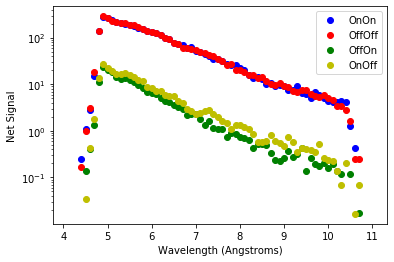

In [4]:
plt.yscale('log')
plt.xlabel('Wavelength (Angstroms)')
plt.ylabel('Net Signal')
plt.plot(Lambda,OnOn,'bo', label='OnOn')
plt.plot(Lambda,OffOff,'ro', label='OffOff')
plt.plot(Lambda,OffOn,'go', label='OffOn')
plt.plot(Lambda,OnOff,'yo', label='OnOff')
plt.legend(loc='upper right')
plt.show()


# Exclude regions with low signal.

Original wavelength range: 4.1 to 11.0
 Working wavelength range: 4.962499916553497 to 10.137499988079071


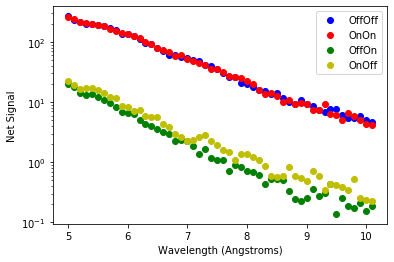

In [5]:
#
# exclude nfac percentage of the band from either end.
#
nfac = 0.125
lmin = np.amin(Lambda)
lmax = np.amax(Lambda)
l0 = lmin + nfac * (lmax-lmin)
l1 = lmax - nfac * (lmax-lmin)
print('Original wavelength range: %s to %s'%(np.amin(Lambda),np.amax(Lambda)))
print(' Working wavelength range: %s to %s'%(l0,l1))
n = len(Lambda)
cull = np.ones(n,dtype=np.byte)
for i in range(n):
    if Lambda[i] < l0: cull[i] = 0
    if Lambda[i] > l1: cull[i] = 0
cull
#
# define the new working arrays
#
m = sum(cull)
L = np.zeros(m,dtype=np.float32)
T = np.zeros(m,dtype=np.float32)
mm = np.zeros(m,dtype=np.float32)
pp = np.zeros(m,dtype=np.float32)
mp = np.zeros(m,dtype=np.float32)
pm = np.zeros(m,dtype=np.float32)
k = 0
for i in range(n):
    if cull[i]:
        L[k]=Lambda[i]
        T[k]=Tof[i]
        pp[k]=OnOn[i]
        mm[k]=OffOff[i]
        mp[k]=OffOn[i]
        pm[k]=OnOff[i]
        k = k + 1
plt.yscale('log')
plt.xlabel('Wavelength (Angstroms)')
plt.ylabel('Net Signal')
plt.plot(L,mm,'bo', label='OffOff')
plt.plot(L,pp,'ro', label='OnOn')
plt.plot(L,mp,'go', label='OffOn')
plt.plot(L,pm,'yo', label='OnOff')
plt.legend(loc='upper right')
plt.show()  

# Define a function that for input uses the efficiencies, e, f, F1, F2 and returns the expected measurables normalized to unit length.

In [6]:
#
# e,f,F1,F2 are front flipper efficiency, backflipper efficiency, front and back flipping ratios of polarizers.
#
def efficiency_function(x):
    e = x[0]
    f = x[1]
    F1 = x[2]
    F2 = x[3]
    monon = (1-f-e+2*e*f+(e+f-2*e*f)*F2+F1*(e+f-2*e*f+(1-e-f+2*e*f)*F2))/(1+F2)/(1+F1)
    moffoff = (1+F1*F2)/(1+F2)/(1+F1)
    monoff = (1-e+e*F2+F1*(e+(1-e)*F2))/(1+F2)/(1+F1)
    moffon = (1-f+f*F2+F1*(f+(1-f)*F2))/(1+F2)/(1+F1)
    f = np.array([moffoff, monon, moffon, monoff])
    n_guess = np.linalg.norm(f)
    f = f / n_guess
    return f
    

# This function returns the difference between the observations and guess

In [7]:
#
# e,g,F1,F2 are front flipper efficiency, backflipper efficiency, front and back flipping ratios of polarizers.
# this function requires the observables and evaluates the difference
#
def difference_function(x,t,o):
    f = efficiency_function(x)
    g = f - o
    return g

# User provides an initial guess for e, f, F1, F2. Displays results.

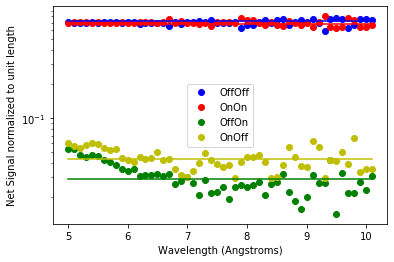

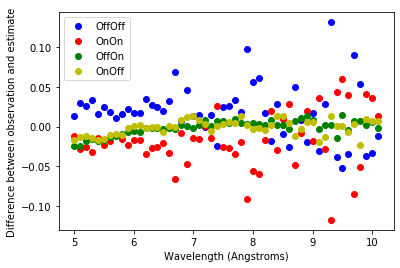

In [8]:
#
# Define initial values for e,f,F1 and F2
#
e = 0.96
f = 0.98
F1 = 100.
F2 = 100.
# dummy array for difference_efficiencies
t = np.array([0,1,2,3])
#
# assemble observations and guesses into seaparte matrices. 
#
Obs = np.zeros((m,4),dtype=np.float32)
Guess = np.zeros((m,4),dtype=np.float32)
Diff = np.zeros((m,4),dtype=np.float32)
for i in range(m):
    Obs[i] = [mm[i],pp[i],mp[i],pm[i]]
    n_obs = np.linalg.norm(Obs[i])
    Obs[i] = Obs[i] / n_obs
    a_guess = np.array([e, f, F1, F2])
    Guess[i] = efficiency_function(a_guess)
    Diff[i] = difference_function(a_guess,t,Obs[i])
plt.yscale('log')
plt.xlabel('Wavelength (Angstroms)')
plt.ylabel('Net Signal normalized to unit length')
plt.plot(L,Obs[:,0],'bo', label='OffOff')
plt.plot(L,Obs[:,1],'ro', label='OnOn')
plt.plot(L,Obs[:,2],'go', label='OffOn')
plt.plot(L,Obs[:,3],'yo', label='OnOff')
plt.legend(loc='best')


#
plt.plot(L,Guess[:,0],'b')
plt.plot(L,Guess[:,1],'r')
plt.plot(L,Guess[:,2],'g')
plt.plot(L,Guess[:,3],'y')
plt.show() 
#
plt.yscale('linear')
plt.xlabel('Wavelength (Angstroms)')
plt.ylabel('Difference between observation and estimate')
plt.plot(L,Diff[:,0],'bo', label='OffOff')
plt.plot(L,Diff[:,1],'ro', label='OnOn')
plt.plot(L,Diff[:,2],'go', label='OffOn')
plt.plot(L,Diff[:,3],'yo', label='OnOff')
plt.legend(loc='upper left')
plt.show() 

# Perform least square analysis to optimize e, f, F1 and F2. User provides an initial guess.

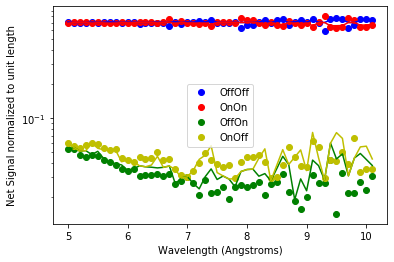

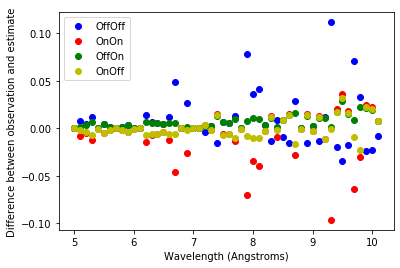

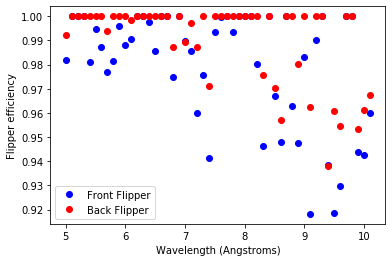

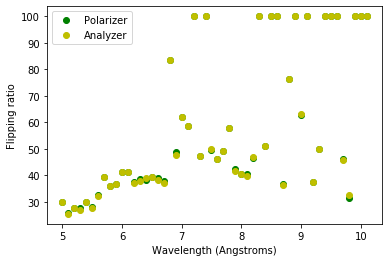

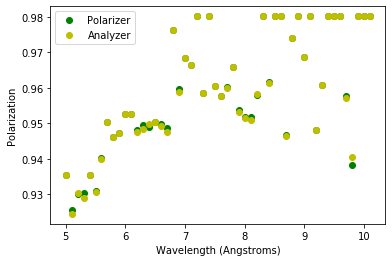

In [9]:
#
# Define initial values for e,f,F1 and F2
# User modifies the next 4 lines.
e = 0.96
f = 0.98
F1 = 100.
F2 = 100.
# End of user modification.
#
a_guess = np.array([e, f, F1, F2])
# 4-elements in observable and guess vector
t = np.array([0,1,2,3])
# record the answers
Diff = np.zeros((m,4),dtype=np.float32)
Guess = np.zeros((m,4),dtype=np.float32)
Ans = np.zeros((m,4),dtype=np.float32)
#
for i in range(m):
    res_lsq = sop.least_squares(difference_function, a_guess, args=(t,Obs[i]),\
                           bounds=([0.,0.,1.,1.],[1.,1.,100.,100]))
    Ans[i] = res_lsq.x
    Guess[i] = efficiency_function(Ans[i])
    Diff[i] = difference_function(Ans[i],t,Obs[i])
plt.yscale('log')
plt.xlabel('Wavelength (Angstroms)')
plt.ylabel('Net Signal normalized to unit length')
plt.plot(L,Obs[:,0],'bo', label='OffOff')
plt.plot(L,Obs[:,1],'ro', label='OnOn')
plt.plot(L,Obs[:,2],'go', label='OffOn')
plt.plot(L,Obs[:,3],'yo', label='OnOff')
plt.legend(loc='best')

#
plt.plot(L,Guess[:,0],'b')
plt.plot(L,Guess[:,1],'r')
plt.plot(L,Guess[:,2],'g')
plt.plot(L,Guess[:,3],'y')
plt.show() 
#
plt.yscale('linear')
plt.xlabel('Wavelength (Angstroms)')
plt.ylabel('Difference between observation and estimate')
plt.plot(L,Diff[:,0],'bo', label='OffOff')
plt.plot(L,Diff[:,1],'ro', label='OnOn')
plt.plot(L,Diff[:,2],'go', label='OffOn')
plt.plot(L,Diff[:,3],'yo', label='OnOff')
plt.legend(loc='upper left')
plt.show() 
#
plt.yscale('linear')
plt.xlabel('Wavelength (Angstroms)')
plt.ylabel('Flipper efficiency')
plt.plot(L,Ans[:,0],'bo', label='Front Flipper')
plt.plot(L,Ans[:,1],'ro', label='Back Flipper')
plt.legend(loc='lower left')
plt.show() 
#
plt.yscale('linear')
plt.xlabel('Wavelength (Angstroms)')
plt.ylabel('Flipping ratio')
plt.plot(L,Ans[:,2],'go',label='Polarizer')
plt.plot(L,Ans[:,3],'yo',label='Analyzer')
plt.legend(loc='upper left')
plt.show() 
#
plt.yscale('linear')
plt.xlabel('Wavelength (Angstroms)')
plt.ylabel('Polarization')
plt.plot(L,(Ans[:,2]-1)/(Ans[:,2]+1),'go',label='Polarizer')
plt.plot(L,(Ans[:,3]-1)/(Ans[:,3]+1),'yo',label='Analyzer')
plt.legend(loc='upper left')
plt.show() 

# Calculate parameters of a polynomial fit through the results.

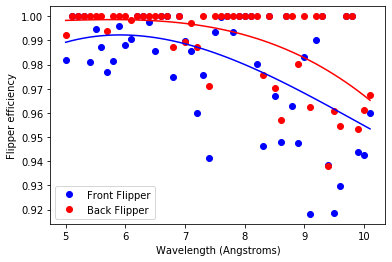

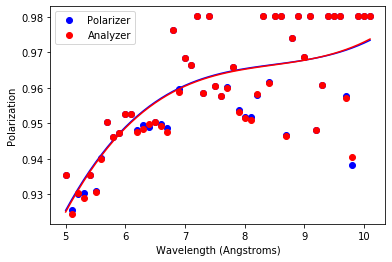

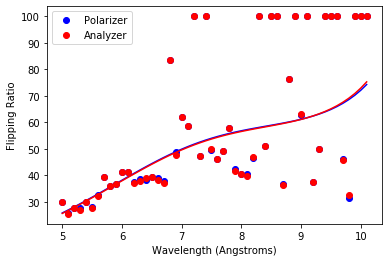

In [10]:
#
e_p = np.polyfit(L,Ans[:,0],3)
e_fit = np.polyval(e_p,L)
#
f_p = np.polyfit(L,Ans[:,1],3)
f_fit = np.polyval(f_p,L)
#
p1 = (Ans[:,2]-1.)/(Ans[:,2]+1.)
p1_p = np.polyfit(L,p1,3)
p1_fit = np.polyval(p1_p,L)
#
p2 = (Ans[:,3]-1.)/(Ans[:,3]+1.)
p2_p = np.polyfit(L,p2,3)
p2_fit = np.polyval(p2_p,L)
#
plt.yscale('linear')
plt.xlabel('Wavelength (Angstroms)')
plt.ylabel('Flipper efficiency')
plt.plot(L,Ans[:,0],'bo', label='Front Flipper')
plt.plot(L,Ans[:,1],'ro', label='Back Flipper')
plt.plot(L,e_fit,'b')
plt.plot(L,f_fit,'r')
plt.legend(loc='lower left')
plt.show() 
#
plt.yscale('linear')
plt.xlabel('Wavelength (Angstroms)')
plt.ylabel('Polarization')
plt.plot(L,p1,'bo',label='Polarizer')
plt.plot(L,p1_fit,'b')
plt.plot(L,p2,'ro',label='Analyzer')
plt.plot(L,p2_fit,'r')
plt.legend(loc='upper left')
plt.show() 
#
plt.yscale('linear')
plt.xlabel('Wavelength (Angstroms)')
plt.ylabel('Flipping Ratio')
plt.plot(L,(p1+1.)/(1.-p1),'bo',label='Polarizer')
plt.plot(L,(p1_fit+1.)/(1.-p1_fit),'b')
plt.plot(L,(p2+1.)/(1.-p2),'ro',label='Analyzer')
plt.plot(L,(p2_fit+1.)/(1.-p2_fit),'r')
plt.legend(loc='upper left')
plt.show() 


In [13]:
np.savez('Efficiencies.npz',e_p,f_p,p1_p,p2_p)

In [14]:
print(e_p)
print(f_p)
print(p1_p)
print(p2_p)

[ 2.84340027e-04 -8.45036340e-03  7.01031160e-02  8.14425218e-01]
[-2.41133063e-04  3.43854380e-03 -1.55967781e-02  1.02043638e+00]
[ 0.00078612 -0.02002318  0.17221392  0.46668403]
[ 0.00080354 -0.02039815  0.17494266  0.45977713]
